k: 8 [25 66  7 93  4 54 36 76]
Max old basis 3: 2.3515175370583212
k: 8 [25 66  7 93  4 54 36 76]


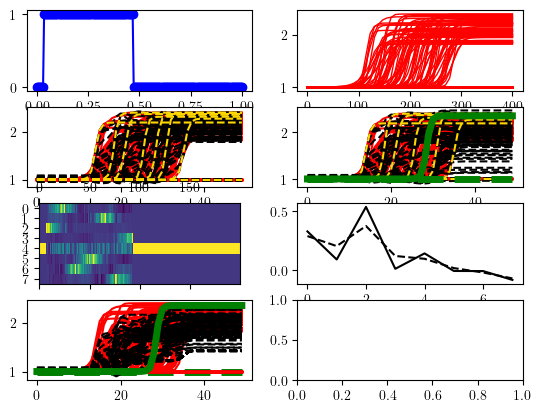

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(4, 2)
N = 200  #number of samples


# Logistic growth function
def logistic_growth(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


xi = np.linspace(0, 1, N)

ig = np.sin(xi * 2 * np.pi)
ig[ig > 0.2] = 1
ig[ig < 0.2] = 0

ax[0, 0].plot(xi, ig, 'b-o')
ax[0, 0].set_xlabel('xi')

t1 = 400
Nt = 50

t_vec = np.linspace(0, t1, Nt)

x0_vec = np.zeros_like(xi)

A = np.zeros((len(t_vec), N))
for i in range(N):
    if ig[i] > 1e-3:
        x0 = xi[i] * t1 + 100
        L = np.random.rand(1)[0] * 0.6 + 0.8
        k = np.random.rand(1)[0] * 0.2 + 0.05

    else:
        x0 = 1000
        L = np.random.rand(1)[0] * 1
        k = 0.1

    x0_vec[i] = x0

    P = logistic_growth(t_vec, L, k, x0) + 1

    A[:, i] = P

    # if i == 80:
    #     AAA
    ax[0, 1].plot(t_vec, P, 'r-', linewidth=1)

ra = np.random.rand(A.shape[0], A.shape[1]) * 0.0
eps = 0.5 * 10 ** -1
k, idx, proj = sli.interp_decomp(A[:, :] + ra, eps)

print('k:', k, idx[:k])
Ac = A[:, idx[:k]]
P = np.hstack([np.eye(k), proj])[:, np.argsort(idx)]

Uh = Ac.dot(P)

for i in range(N):
    ax[1, 0].plot(A[:, i], 'r-')

for i in range(N):
    ax[1, 0].plot(Uh[:, i], 'k--')

for i in range(Ac.shape[1]):
    ax[1, 0].plot(Ac[:, i], '--', color='gold')

Ac = A[:, idx[:k]]
P = np.hstack([np.eye(k), proj])[:, np.argsort(idx)]

ci = 1
print('Max old basis 3:', np.max(Ac[:, ci]))

ax[1, 1].plot(Ac[:, ci], 'g-', linewidth=5, zorder=200)
Ac[:, ci] = 0 * Ac[:, ci] + 1
Uh = Ac.dot(P)
ax[1, 1].plot(Ac[:, ci], 'g--', linewidth=5, zorder=200)

for i in range(N):
    ax[1, 1].plot(A[:, i], 'r-')

for i in range(N):
    ax[1, 1].plot(Uh[:, i], 'k--')

for i in range(Ac.shape[1]):
    ax[1, 1].plot(Ac[:, i], '--', color='gold')

ind = 14
sig_s = 0.6
ax[2, 0].matshow(P, aspect=10)
ax[2, 1].plot(P[:, ind], 'k-')  #, aspect=10)
smoothed_signal = gaussian_filter1d(P[:, ind], sig_s)
factor = np.sum(P[:, ind]) / np.sum(smoothed_signal)
ax[2, 1].plot(smoothed_signal * factor, 'k--')  #, aspect=10)

mod_P = np.zeros_like(P)
for i in range(P.shape[1]):
    mod_P[:, i] = gaussian_filter1d(P[:, i], sig_s)

print('k:', k, idx[:k])
Ac = A[:, idx[:k]]
# P            = np.hstack([np.eye(k), proj])[:,np.argsort(idx)]

ax[3, 0].plot(Ac[:, ci], 'g-', linewidth=5, zorder=200)
Ac[:, ci] = 0 * Ac[:, ci] + 1
Uh = Ac.dot(mod_P)
ax[3, 0].plot(Ac[:, ci], 'g--', linewidth=5)

for i in range(N):
    ax[3, 0].plot(A[:, i], 'r-')

for i in range(N):
    ax[3, 0].plot(Uh[:, i], 'k--')
    

    




In [100]:
from scipy.optimize import minimize

k, idx, proj = sli.interp_decomp(A, 0.05)

print(k)
print(proj.shape)

A = A  # Original data matrix
B = A[:,idx[:k]]  # Skeleton matrix
C = A[:,idx[k:]]  # Non - skeleton matrix

assert np.mean(C - B.dot(proj)) < 1e-3

8
(8, 192)


In [101]:
# Manually optimise the interpolation weights

def objective_fn(p):
    p = p.reshape(proj.shape)
    f = 0.5 * np.sum((B.dot(p) - C)**2)
    return f

def gradient_fn(p):
    p = p.reshape(proj.shape)
    return B.T.dot(B.dot(p) - C).flatten()

def objective_fn_quadratic_regularised(p, alpha=1.0):
    """Experiment with quadratic regularisation which penalises the distance of each projection weight from the mean weight
    """
    p = p.reshape(proj.shape)
    mean_weight = np.mean(proj)
    f = 0.5 * np.sum((B.dot(p) - C)**2) + alpha * np.sum((p - mean_weight)**2)
    return f

def gradient_fn_quadratic_regularised(p, alpha=1.0):
    p = p.reshape(proj.shape)
    mean_weight = np.mean(p)
    grad = B.T.dot(B.dot(p) - C) + alpha * 2 * (p - mean_weight)
    return grad.flatten()

x0 = np.random.rand(8*192)
res = minimize(objective_fn, x0, jac=gradient_fn, method='BFGS', options={'disp': True, 'maxiter': 50})
res_quad_reg = minimize(objective_fn_quadratic_regularised, x0, jac=gradient_fn_quadratic_regularised, method='BFGS', options={'disp': True, 'maxiter': 50})

Optimization terminated successfully.
         Current function value: 2.981110
         Iterations: 26
         Function evaluations: 43
         Gradient evaluations: 43
         Current function value: 84.348887
         Iterations: 29
         Function evaluations: 104
         Gradient evaluations: 92


/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


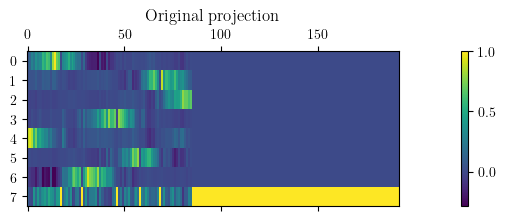

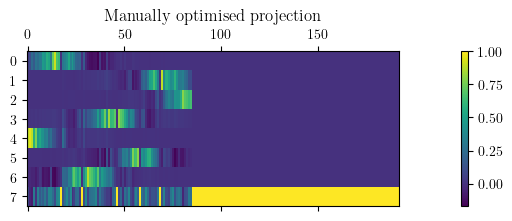

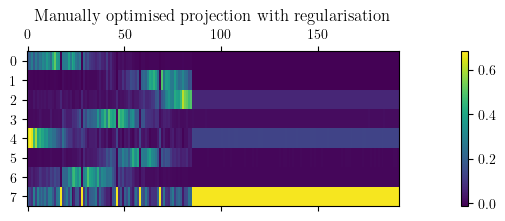

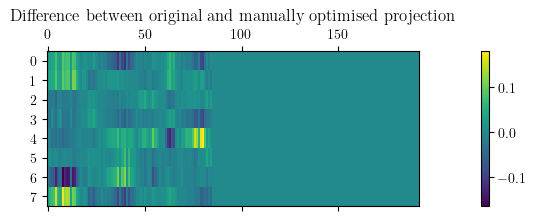

In [102]:
proj_min = res.x.reshape(8, 192)
proj_reg = res_quad_reg.x.reshape(8, 192)

# Compare the original projection with the manually optimised projection

im = plt.matshow(proj, aspect=10)
plt.colorbar(im)
plt.title('Original projection')
plt.show()

im = plt.matshow(proj_min, aspect=10)
plt.colorbar(im)
plt.title('Manually optimised projection')
plt.show()

im = plt.matshow(proj_reg, aspect=10)
plt.colorbar(im)
plt.title('Manually optimised projection with quadratic regularisation')
plt.show()

im = plt.matshow(proj - proj_min, aspect=10)
plt.title('Difference between original and manually optimised projection')
plt.colorbar(im)
plt.show()

Mean reconstruction error original: 0.048635195949909754
Mean reconstruction error manual: 0.03105323097035335
Mean reconstruction error regularised: 0.2998527954036811


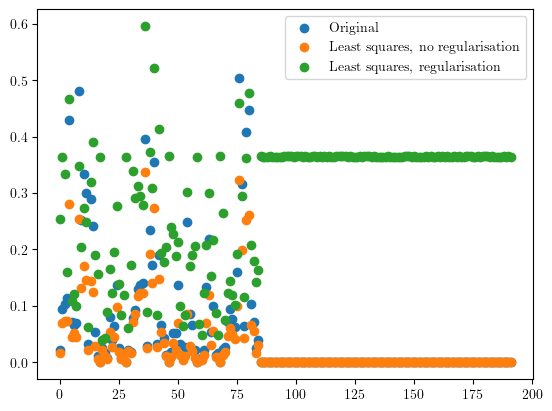

In [103]:
# Reconstruction error for each non-skeleton vector as a scatter plot
reconstruction_error_original = np.sum((C - B.dot(proj))**2, axis=0)
reconstruction_error_manual = np.sum((C - B.dot(proj_min))**2, axis=0)
reconstruction_error_regularised = np.sum((C - B.dot(proj_reg))**2, axis=0)
print(f'Mean reconstruction error original: {np.mean(reconstruction_error_original)}')
print(f'Mean reconstruction error manual: {np.mean(reconstruction_error_manual)}')
print(f'Mean reconstruction error regularised: {np.mean(reconstruction_error_regularised)}')

plt.scatter(range(len(reconstruction_error_original)), reconstruction_error_original, label='Original')
plt.scatter(range(len(reconstruction_error_manual)), reconstruction_error_manual, label='Least squares, no regularisation')
plt.scatter(range(len(reconstruction_error_regularised)), reconstruction_error_regularised, label='Least squares, regularisation')
plt.legend()
plt.show()

# Notes

- The least squares optimisation problem converges to a slightly lower reconstruction error than the original interpolation weights from ID
- Quadratic regularisation doesn't help- the reconstruction error is far higher. This is partly because the non-igniting runs depend on a single basis vector so by definition the interpolation weights must be a one-hot vector. Regularisation is not helpful in this case.

In [107]:
# If we randomly remove one of the basis columns, how does the reconstruction error change?
# Remove index 4 from the skeleton matrix

B_reduced = np.delete(B, 4, axis=1)
proj_reduced = np.delete(proj, 4, axis=0)

def objective_fn(p):
    p = p.reshape(proj_reduced.shape)
    f = 0.5 * np.sum((B_reduced.dot(p) - C)**2)
    return f

def gradient_fn(p):
    p = p.reshape(proj_reduced.shape)
    return B_reduced.T.dot(B_reduced.dot(p) - C).flatten()

x0 = np.random.rand(7*192)
res = minimize(objective_fn, x0, jac=gradient_fn, method='BFGS', options={'disp': True, 'maxiter': 50})

Optimization terminated successfully.
         Current function value: 11.042574
         Iterations: 25
         Function evaluations: 36
         Gradient evaluations: 36


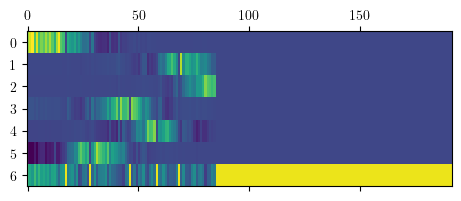

In [109]:
plt.matshow(res.x.reshape(proj_reduced.shape), aspect=10)

Mean reconstruction error: 0.11502681327993093


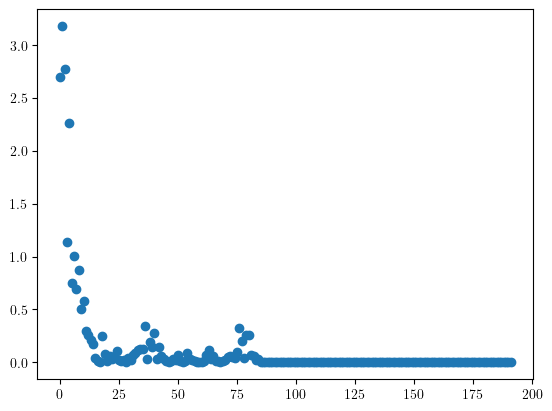

In [110]:
reconstruction_error = np.sum((C - B_reduced.dot(res.x.reshape(proj_reduced.shape)))**2, axis=0)
print(f'Mean reconstruction error: {np.mean(reconstruction_error)}')
plt.scatter(range(len(reconstruction_error)), reconstruction_error)
plt.show()

# Notes

- I chose this basis vector since it was heavily used to reconstruct the first few runs. After removing it, the least squares optimisation is unable to find a new set of interpolation weights which correct for the loss of this basis vector, shown by the large error in the first 10 runs.
- In general, we are probably not robust to just removing a basis vector and recomputing the optimal interpolation weights. Therefore, the basis functions are kind of orthogonal, since we need all of them to accurately reconstruct the other functions. (they form a minimal spanning set over our data).
- Could we encourage the interpolative decomposition to assemble a low-rank skeleton matrix, as this would have the redundancy we need to be robust to the loss of a basis vector? - probably not, since this would be in direct contradiction to the reconstruction objective.